In [1]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

In [2]:
import fca_interp as fcai

In [3]:
from utils_ import powerset

In [4]:
from importlib import reload

In [5]:
from sklearn.datasets import load_boston

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import os
import cx_Oracle
import sys
sys.path.append(os.path.abspath('/opt/jupyter/notebook/lib'))
import ImportExport

In [8]:
scheme = 'edudyrev'
psw = 'WHspace10'

model_files_cols = ["id_", "name_", "data_", "version_"]
os.environ['NLS_LANG'] = 'American_America.AL32UTF8'

In [9]:
con_str = f'{scheme}/{psw}@(DESCRIPTION=(ADDRESS=(PROTOCOL=tcp)(HOST=ex6s-scan.gksm.local)(PORT=1521))(CONNECT_DATA=(SERVICE_NAME=forecast)))'
l_ora_conn=cx_Oracle.connect(con_str)
c = l_ora_conn.cursor()

In [10]:
imp_exp = ImportExport.ImportExport(p_in_username = 'edudyrev',
    p_in_pass = 'WHspace10',
    p_in_schema ='edudyrev',
    #p_in_host = "ex6s-scan.gksm.local",
    p_in_host = "ex6s-scan.gksm.local",
    p_in_service_name = "forecast",
    p_in_hdfs_path = 'hdfs://bigdata-ns/h2o/dev/',
    p_in_debug=1,
    )

In [16]:
c.execute("""select key_col_name, numeric_columns, factor_columns, accum_columns from shops_mod.v_forecast_models where model_id=3""")
key_cols, num_cols, factor_cols, acc_cols = c.fetchall()[0]

In [17]:
key_cols = key_cols.upper().split(',')
num_cols = num_cols.upper().split(',')
factor_cols = factor_cols.upper().split(',')
acc_cols = acc_cols.upper().split(',')

In [18]:
key_cols

['ID_OBJ', 'STYLECOLORID', 'DATE_']

In [14]:
num_cols

'BONUS_NEXT_WEEK_END,DISC_CHANGE,DISC_CHANGE_PERC,DISCOUNT_LEVEL,DISCOUNT_LEVEL_LW,NSIZE,OOS,PERIOD_NUMBER,PLAN_DISC,PROMO_PERIOD,PROMO_TYPE_M_WKE_11,PROMO_TYPE_M_WKE_12,PROMO_TYPE_M_WKE_16,PROMO_TYPE_M_WKE_3,PROMO_TYPE_M_WKE_9,PROMO_TYPE_M_WKS_11,PROMO_TYPE_M_WKS_12,PROMO_TYPE_M_WKS_16,PROMO_TYPE_M_WKS_3,PROMO_TYPE_M_WKS_9,PROMO_TYPE_M_11,PROMO_TYPE_M_12,PROMO_TYPE_M_15,PROMO_TYPE_M_16,PROMO_TYPE_M_9,PROMO_TYPE_P_WKE_12,PROMO_TYPE_P_WKE_16,PROMO_TYPE_P_WKE_9,PROMO_TYPE_P_WKS_12,PROMO_TYPE_P_WKS_16,PROMO_TYPE_P_WKS_9,PROMO_TYPE_P_12,PROMO_TYPE_P_16,PROMO_TYPE_P_9,QTYUPA,WEEKNUMBER_FROM_INTAKEDATE,WORKDAYS_IT_CNT,N_DAY_YEAR,PROMO_TYPE_S_21,PROMO_TYPE_S_24,PROMO_TYPE_S_WKE_21,PROMO_TYPE_S_WKE_24,PROMO_TYPE_S_WKS_21,PROMO_TYPE_S_WKS_24,SPWPLAN,N_DAY_YEAR_COS,MIN_STORE_AGE_IN_MONTHS,MIN_STORE_AGE_IN_YEARS,TEMPERATURE_LAG1_DIFF,TEMPERATURE_LEAD1_DIFF,TEMPERATURE_LEAD2_DIFF,TEMPERATURE_PART_LEAD1,TEMPERATURE_PART_LEAD2,WEEKNUMBER_FROM_FIRST_RST,COOLING,HEATING,IS_PRECIPITATION,WEIGHT'

In [6]:
real_feats = ['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'balance',]
cat_feats  = ['job', 'marital', 'education', 'contact', 'month', 'poutcome',]

In [7]:
bank_ds = pd.read_csv('bank_ds_new.csv', index_col=0)
bank_ds.index = bank_ds.index.astype(str)

In [256]:
bb = CatBoostClassifier(cat_features=cat_feats)
bb.fit(bank_ds[cat_feats+real_feats], bank_ds['y'], verbose=False, plot=False)
bank_ds['preds'] = bb.predict(bank_ds[cat_feats+real_feats])

In [8]:
def calc_cover_of_concepts(concepts):
    return set([str(g) for c in concepts for g in c.get_extent()])

In [9]:
def get_min_concepts(concepts, use_tqdm=True):
    concepts = sorted(concepts, key=lambda c: -len(c.get_extent()))
    for i in tqdm(range(len(concepts)), disable=not use_tqdm):
        if i >= len(concepts):
            break
        
        c = concepts[i]
        lns = set([c_ for c_ in concepts if c_!=c and c_.is_subconcept_of(c)])
        concepts = [c_ for c_ in concepts if c_ not in lns]
    return concepts

In [10]:
def select_smallest_covering_hyps(concepts, use_tqdm=True, use_pruning=False):
    selected_hyps = []
    n_added = []
    n_covered = []
    for i in tqdm(range(len(concepts)), disable=not use_tqdm):
        cncpts_to_check = [c for c in concepts if c not in selected_hyps]
        if len(cncpts_to_check)==0:
            break
        cover = calc_cover_of_concepts(selected_hyps)
        for c in cncpts_to_check:
            c._metrics['n_uncovered'] = len([g for g in c.get_extent() if g not in cover])
        cncpts_to_check = sorted(cncpts_to_check, key=lambda c: (-c._metrics['n_uncovered'], -c._metrics['strongness']))
        n_ = cncpts_to_check[0]._metrics['n_uncovered']
        if n_==0:
            break
        selected_hyps.append(cncpts_to_check[0])
        n_added.append(n_)
        n_covered.append(len(calc_cover_of_concepts(selected_hyps)))
        
    if use_pruning:
        for i in tqdm(range(len(selected_hyps)), desc='pruning', disable=not use_tqdm):
            cover = len(calc_cover_of_concepts(selected_hyps))
            for c in selected_hyps:
                cover_ = len(calc_cover_of_concepts([c_ for c_ in selected_hyps if c_!=c]))
                if cover_==cover:
                    selected_hyps = [c_ for c_ in selected_hyps if c_!=c]
                    break
            else:
                break
    
    return selected_hyps

In [11]:
def construct_bin_ds_from_ints(ints_, bin_ds_old):
    bin_ds = pd.DataFrame()
    for idx, int_ in enumerate(ints_):
        bin_ds[f'int_{idx}'] = bin_ds_old[int_].all(1)
    bin_ds.index = bin_ds_old.index
    return bin_ds

# Анализируем положительные примеры

In [12]:
import fca_interp as fcai

In [13]:
import pattern_structure as ps_lib

In [14]:
ps_lib = reload(ps_lib)

In [62]:
fcai = reload(fcai)

In [63]:
flg = bank_ds['preds']==1
flg.sum()

149

In [64]:
mvcntx = fcai.MultiValuedContext(bank_ds.loc[flg, cat_feats+real_feats].head(5), cat_attrs=cat_feats)
mvcntx_full = fcai.MultiValuedContext(bank_ds[cat_feats+real_feats], cat_attrs=cat_feats)

In [65]:
fm = fcai.FormalManager(mvcntx)

In [66]:
fm.construct_concepts()

In [67]:
fm.calc_strongness(mvcntx_full)

In [68]:
fm.construct_lattice()

In [69]:
fm.calc_stability_approx()

In [70]:
fig = fm.get_plotly_fig(color_by='strongness')

In [71]:
fig

In [73]:
from sklearn.metrics import accuracy_score

In [125]:
fcai = reload(fcai)

In [126]:
mvcntx = fcai.MultiValuedContext(bank_ds.loc[flg, cat_feats+real_feats], cat_attrs=cat_feats)
mvcntx_full = fcai.MultiValuedContext(bank_ds[cat_feats+real_feats], cat_attrs=cat_feats)

In [127]:
from datetime import datetime

In [128]:
def construct_max_strong_hyps(cntx, cntx_full, use_tqdm=True):
    concept_class = fcai.Concept if type(cntx)==fcai.BinaryContext else fcai.PatternStructure
    objs_to_check = sorted(cntx.get_objs(is_full=True))

    concepts = []
    for i in tqdm(range(len(objs_to_check)), disable=not use_tqdm):
        if len(objs_to_check)==0:
            break
        g = objs_to_check.pop(0)

        int_ = cntx.get_intent([g],)
        ext_ = cntx.get_extent(int_)    
        ext_full = cntx_full.get_extent(int_)
        strongness = len(ext_)/len(ext_full) if len(ext_)>0 else 0
        assert strongness==1, f'Object {g} is not a strong hypothesis'

        objs_to_check = [g_ for g_ in objs_to_check if g_ not in ext_]
        if concept_class==fcai.Concept:
            c = concept_class(ext_, int_, metrics={'strongness':strongness})
        else:
            c = concept_class(ext_, int_, metrics={'strongness':strongness}, cat_feats=list(mvcntx._attrs[mvcntx._cat_attrs_idxs]))
        concepts.append(c)
    return concepts

In [130]:
def _close_by_one_concepts(cntx, cntx_full, strong_concepts, is_monotonic=False, strongness_min_bound=0.5, verb=True, concept_class=fcai.Concept):
    if type(cntx)==fcai.MultiValuedContext:
        concept_class = fcai.PatternStructure
    else:
        concept_class = fcai.Concept
    
    n_concepts = len(strong_concepts)

    combs_to_check = [[g_idx] for g_idx in range(len(strong_concepts))]
    concepts = set()
    iter_ = 0
    saved_combs = set()

    t0 = datetime.now()
    while len(combs_to_check) > 0:
        iter_ += 1

        comb = combs_to_check.pop(0)
        
        try:
            ext_united = list(set([g for c_idx in comb for g in strong_concepts[c_idx].get_extent()])) #transforming concepts to their common extents
        except Exception as e:
            if verb:
                print(comb, e)
            raise e
        if concept_class==fcai.Concept:
            int_ = cntx.get_intent(ext_united, trust_mode=False, verb=True, is_full=True)
            ext_ = cntx.get_extent(int_, trust_mode=False, verb=True, is_full=True)
        else:
            int_ = cntx.get_intent(ext_united, trust_mode=False, verb=True,)
            ext_ = cntx.get_extent(int_, trust_mode=False, verb=True)
        
        comb_ = [idx for idx, concept in enumerate(strong_concepts) if all([g in ext_ for g in concept.get_extent()])] #transforming extents to their concepts
        
        new_comb_ = [x for x in comb_ if x not in comb]

        t1 = datetime.now()
        dt = (t1 - t0).total_seconds()
        try:
            if verb:
                print(f"{iter_}: len(comb_)={len(comb_)}, first_in_comb: {comb_[0]}, new_comb_len:{len(new_comb_)}, time spend: {dt:.2f} sec, speed: {dt / iter_:.2f} sec/iter")
        except Exception as e:
            if verb:
                print(comb, comb_, e)
            raise e

        if (len(comb) > 0 and any([x < comb[-1] for x in new_comb_])) or tuple(comb_) in saved_combs:
            continue
            
        if strongness_min_bound is not None:
            if concept_class==fcai.Concept:
                ext_full = cntx.get_extent(int_, trust_mode=False, verb=True, is_full=True)
                ext_full_ = cntx_full.get_extent(int_, trust_mode=False, verb=True, is_full=True)
            else:
                ext_full = cntx.get_extent(int_, trust_mode=False, verb=True)
                ext_full_ = cntx_full.get_extent(int_, trust_mode=False, verb=True)
            strongness = len(ext_full)/len(ext_full_) if len(ext_full)>0 else 0
            if strongness<strongness_min_bound:
                continue

        
        if concept_class==fcai.Concept:
            c = concept_class(ext_, int_)
        else:
            c = concept_class(ext_, int_, cat_feats=cntx._attrs[cntx._cat_attrs_idxs])
        concepts.add(c)
        
        saved_combs.add(tuple(comb_))

        new_combs = [comb_ + [x] for x in range((comb[-1] if len(comb) > 0 else -1) + 1, n_concepts) if x not in comb_]
        combs_to_check = new_combs + combs_to_check

    return concepts

In [131]:
def unite_bootstrap_concepts(cntx, cntx_full, base_concepts, n_epochs=500, sample_size=15, use_tqdm=True, stab_min_bound=None, verb=False,
                                 strongness_min_bound=0.5, n_best_concepts=None, is_monotone=False):
    concepts_bootstrap = []
    for i in tqdm(range(n_epochs), disable=not use_tqdm, desc='boostrap aggregating'):
        np.random.seed(i)
        sample = np.random.choice(base_concepts, size=sample_size, replace=True)
        concepts = _close_by_one_concepts(cntx, cntx_full, sample, is_monotonic=False, strongness_min_bound=strongness_min_bound, verb=False)
        fm = fcai.FormalManager(cntx)
        fm._concepts = concepts
        fm.calc_strongness(cntx_full)
        for idx, c in enumerate(fm.sort_concepts(concepts)):
            c._idx = idx
        fm.construct_lattice()
        fm.calc_stability_approx()
        if stab_min_bound is not None:
            fm.filter_concepts(lambda c: fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=stab_min_bound)
        
        concepts = list(fm.get_concepts())
        if n_best_concepts is not None:
            #concepts = sorted(concepts, key=lambda c: (-c._metrics.get('stab_min_bound',0), -c._metrics.get('strongness',0)))[:n_best_concepts]
            concepts = sorted(concepts, key=lambda c: (-fcai.get_not_none(c._metrics['stab_min_bound'],-100), -fcai.get_not_none(c._metrics['strongness'],-100)))[:n_best_concepts]
        
        concepts_bootstrap += concepts
    return concepts_bootstrap

In [164]:
!pip install frozendict

  Created wheel for frozendict: filename=frozendict-1.2-py3-none-any.whl size=3148 sha256=650bfaefccf0469def26babe1a954a511102907d589d97783b70784f2da755b7
  Stored in directory: /root/.cache/pip/wheels/68/17/69/ac196dd181e620bba5fae5488e4fd6366a7316dce13cf88776
Successfully built frozendict


In [165]:
from frozendict import frozendict

In [169]:
frozendict({'d':4, 'c':3}) in set(['a','b', frozendict({'c':3,'d':4})])

True

In [170]:
def get_unique_concepts(concepts):
    saw_ints = set()
    unique_concepts = []
    for c in concepts:
        if c.get_intent() is None:
            continue
            
        int_ = tuple(c.get_intent()) if type(c)==fcai.Concept else frozendict(c.get_intent())
        if int_ not in saw_ints:
            unique_concepts.append(c)
            saw_ints.add(int_)
    return unique_concepts

In [171]:
def agglomerative_concepts_construction(cntx, cntx_full, base_concepts, strongness_delta=0.1, stab_min_bound=0.5, bootstrap_sample_size=15,
                                        use_tqdm=True, n_epochs_bootstrap=100, n_best_concepts_bootstrap=10, verb=True):
    concept_class = {fcai.BinaryContext: fcai.Concept, fcai.MultiValuedContext: fcai.PatternStructure}[type(cntx)]
    if concept_class==fcai.Concept:
        int_ = cntx.get_intent([], is_full=True)
        ext_ = cntx.get_extent(int_, is_full=True)
        ext_full = cntx.get_extent(int_, is_full=True)
        bottom_concept = concept_class(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0})
    else:
        int_ = cntx.get_intent([])
        ext_ = cntx.get_extent(int_)
        ext_full = cntx.get_extent(int_)
        bottom_concept = concept_class(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0}, cat_feats=cntx._attrs[cntx._cat_attrs_idxs])
        
    strong_bounds = np.arange(0,1+strongness_delta,strongness_delta)[::-1]
    min_concepts_by_iters = {}
    selected_concepts = []
    
    mc = base_concepts.copy()
    for iter_idx, strong_bound in tqdm(enumerate(strong_bounds), disable=not use_tqdm, total=len(strong_bounds), desc='agglomerative construction'):
        bs_concepts = unite_bootstrap_concepts(cntx, cntx_full, mc, sample_size=bootstrap_sample_size, stab_min_bound=stab_min_bound,
                                               n_epochs=n_epochs_bootstrap, n_best_concepts=n_best_concepts_bootstrap, strongness_min_bound=strong_bound)
        unique_concepts = get_unique_concepts(bs_concepts)
        if verb:
            print(f'Iter {iter_idx}: num bs unique concepts: {len(unique_concepts)}')
        
        concepts = unique_concepts+selected_concepts+[bottom_concept]+(base_concepts if iter_idx==0 else [])
        if verb:
            print(f'Iter {iter_idx}: num concept to fm: {len(concepts)}')
            
        fm = fcai.FormalManager(cntx)
        fm._concepts = concepts
        for idx, c in enumerate(fm.sort_concepts(concepts)):
            c._idx = idx
        fm.construct_lattice()
        fm.calc_stability_approx()
        concepts = fm.get_concepts()
        
        if verb:
            print(f'Iter {iter_idx}: cover of all concepts: {len(calc_cover_of_concepts(concepts))}')
        stab_concepts = [c for c in concepts if fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=stab_min_bound]
        
        if verb:
            print(f'Iter {iter_idx}: cover of stable concepts: {len(calc_cover_of_concepts(stab_concepts))}')
        
        mc = select_smallest_covering_hyps(stab_concepts, use_pruning=True)
        if verb:
            print(f'Iter {iter_idx}: cover of min stable concepts: {len(calc_cover_of_concepts(mc))}')
            print(f'Iter {iter_idx}: num of min stable concepts: {len(mc)}')
        selected_concepts = get_unique_concepts(selected_concepts+mc)
        if verb:
            print(f'Iter {iter_idx}: num of selected concepts: {len(selected_concepts)}')
            print(f'Iter {iter_idx}: cover of selected concepts: {len(calc_cover_of_concepts(selected_concepts))}')
        min_concepts_by_iters[iter_idx] = mc
    return selected_concepts, min_concepts_by_iters

In [224]:
fcai = reload(fcai)

In [225]:
mvcntx = fcai.MultiValuedContext(bank_ds.loc[flg, cat_feats+real_feats], cat_attrs=cat_feats)
mvcntx_full = fcai.MultiValuedContext(bank_ds[cat_feats+real_feats], cat_attrs=cat_feats)

In [226]:
base_concepts = construct_max_strong_hyps(mvcntx, mvcntx_full)

In [227]:
#int_ = mvcntx.get_intent([])
ext_ = list(mvcntx._objs) #mvcntx.get_extent(int_)
int_ = mvcntx.get_intent(ext_)
ext_full = mvcntx_full.get_extent(int_)
top_concept = fcai.PatternStructure(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0}, cat_feats=mvcntx._attrs[mvcntx._cat_attrs_idxs])

ext_ = []
int_ = mvcntx.get_intent(ext_)
ext_full = mvcntx_full.get_extent(int_)
bottom_concept = fcai.PatternStructure(ext_, int_, metrics={'strongness':len(ext_)/len(ext_full) if len(ext_)>0 else 0}, cat_feats=mvcntx._attrs[mvcntx._cat_attrs_idxs])

In [594]:
selected_concepts, min_concepts_by_iters = agglomerative_concepts_construction(mvcntx, mvcntx_full, base_concepts, bootstrap_sample_size=10,  stab_min_bound=0)


Iter 0: num bs unique concepts: 981
Iter 0: num concept to fm: 1131
Iter 0: cover of all concepts: 149
Iter 0: cover of stable concepts: 149


Iter 0: cover of min stable concepts: 149
Iter 0: num of min stable concepts: 44
Iter 0: num of selected concepts: 44
Iter 0: cover of selected concepts: 149





Iter 1: num bs unique concepts: 60
Iter 1: num concept to fm: 105
Iter 1: cover of all concepts: 149
Iter 1: cover of stable concepts: 149


Iter 1: cover of min stable concepts: 149
Iter 1: num of min stable concepts: 33
Iter 1: num of selected concepts: 52
Iter 1: cover of selected concepts: 149



Iter 2: num bs unique concepts: 10
Iter 2: num concept to fm: 63
Iter 2: cover of all concepts: 149
Iter 2: cover of stable concepts: 149


Iter 2: cover of min stable concepts: 149
Iter 2: num of min stable concepts: 28
Iter 2: num of selected concepts: 56
Iter 2: cover of selected concepts: 149





Iter 3: num bs unique concepts: 7
Iter 3: num concept to fm: 64
Iter 3: cover of all concepts: 149
Iter 3: cover of stable concepts: 149


Iter 3: cover of min stable concepts: 149
Iter 3: num of min stable concepts: 24
Iter 3: num of selected concepts: 59
Iter 3: cover of selected concepts: 149



Iter 4: num bs unique concepts: 1
Iter 4: num concept to fm: 61
Iter 4: cover of all concepts: 149
Iter 4: cover of stable concepts: 149


Iter 4: cover of min stable concepts: 149
Iter 4: num of min stable concepts: 23
Iter 4: num of selected concepts: 60
Iter 4: cover of selected concepts: 149



Iter 5: num bs unique concepts: 4
Iter 5: num concept to fm: 65
Iter 5: cover of all concepts: 149
Iter 5: cover of stable concepts: 149


Iter 5: cover of min stable concepts: 149
Iter 5: num of min stable concepts: 20
Iter 5: num of selected concepts: 63
Iter 5: cover of selected concepts: 149



Iter 6: num bs unique concepts: 0
Iter 6: num concept to fm: 64
Iter 6: cover of all concepts: 149
Iter 6: cover of stable concepts: 149


Iter 6: cover of min stable concepts: 149
Iter 6: num of min stable concepts: 20


Iter 6: num of selected concepts: 63
Iter 6: cover of selected concepts: 149



Iter 7: num bs unique concepts: 10
Iter 7: num concept to fm: 74
Iter 7: cover of all concepts: 149
Iter 7: cover of stable concepts: 149


Iter 7: cover of min stable concepts: 149
Iter 7: num of min stable concepts: 14
Iter 7: num of selected concepts: 67
Iter 7: cover of selected concepts: 149



Iter 8: num bs unique concepts: 15
Iter 8: num concept to fm: 83
Iter 8: cover of all concepts: 149
Iter 8: cover of stable concepts: 149


Iter 8: cover of min stable concepts: 149
Iter 8: num of min stable concepts: 8
Iter 8: num of selected concepts: 71
Iter 8: cover of selected concepts: 149





Iter 9: num bs unique concepts: 7
Iter 9: num concept to fm: 79
Iter 9: cover of all concepts: 149
Iter 9: cover of stable concepts: 149


Iter 9: cover of min stable concepts: 149
Iter 9: num of min stable concepts: 4
Iter 9: num of selected concepts: 73
Iter 9: cover of selected concepts: 149





Iter 10: num bs unique concepts: 10
Iter 10: num concept to fm: 84
Iter 10: cover of all concepts: 149
Iter 10: cover of stable concepts: 149


Iter 10: cover of min stable concepts: 149
Iter 10: num of min stable concepts: 2
Iter 10: num of selected concepts: 74
Iter 10: cover of selected concepts: 149



In [595]:
len(selected_concepts)

74

In [596]:
selected_concepts = sorted(selected_concepts, key=lambda c: len(c.get_extent()))
for i in tqdm(range(len(selected_concepts))):
    if i>= len(selected_concepts):
        break
    c = selected_concepts[i]
    if c._metrics['strongness']<1:
        continue
    low_neighbs = [c_ for c_ in selected_concepts if c_.is_subconcept_of(c) and c!=c_]
    selected_concepts = [c_ for c_ in selected_concepts if c_ not in low_neighbs]

In [597]:
len(selected_concepts)

69

In [598]:
fm = fcai.FormalManager(mvcntx)
#fm._concepts = [fcai.Concept(c.get_extent(), c.get_intent().copy(), metrics=c._metrics.copy()) for c in selected_concepts+[top_concept]+[bottom_concept]]
fm._concepts = [fcai.PatternStructure(c.get_extent(), c.get_intent().copy() if c.get_intent() is not None else None, metrics=c._metrics.copy())
                for c in selected_concepts+[top_concept]+[bottom_concept]]
for idx, c in enumerate(fm.sort_concepts(fm.get_concepts())):
    c._idx = idx
fm.calc_strongness(mvcntx_full)
fm.construct_lattice()
fm.calc_stability_approx()
concepts = fm.get_concepts()

In [599]:
fig = fm.get_plotly_fig(color_by='stab_min_bound', sort_by='strongness', level_sort=3, new_attrs_lim=1, new_objs_lim=1)

/root/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [600]:
fig.show()

In [728]:
concepts_json = {}
for c in fm.get_concepts():
    c_json = {}
    c_json['extent'] = tuple(c.get_extent())
    c_json['intent'] = tuple(c.get_intent()) if c.get_intent() is not None else None
    c_json['low_neighbs'] = tuple(c.get_lower_neighbs())
    c_json['up_neighbs'] = tuple(c.get_upper_neighbs())
    c_json['metrics'] = c._metrics
    concepts_json[c.get_id()] = c_json

In [730]:
import json
with open('pattern_structures_pos.json','w') as f:
    json.dump(concepts_json, f)

In [635]:
stab_concepts = [c for c in fm.get_concepts() if fcai.get_not_none(c._metrics['stab_min_bound'],-100)>=0.95]
len(calc_cover_of_concepts(stab_concepts)), len(stab_concepts), len(calc_cover_of_concepts([c for c in stab_concepts if c._metrics['strongness']>=0.5]))/flg.sum()

(149, 45, 0.8389261744966443)

In [636]:
fm_stab = fcai.FormalManager(mvcntx)
fm_stab._concepts = [fcai.PatternStructure(c.get_extent(), c.get_intent().copy() if c.get_intent() is not None else None, metrics=c._metrics.copy())
                for c in stab_concepts+[top_concept]]
for idx, c in enumerate(fm_stab.sort_concepts(fm_stab.get_concepts())):
    c._idx = idx
fm_stab.calc_strongness(mvcntx_full)
fm_stab.construct_lattice()
fm_stab.calc_stability_approx()
concepts = fm_stab.get_concepts()

In [637]:
fig_stab = fm_stab.get_plotly_fig(color_by='strongness', sort_by='strongness', level_sort=3, new_attrs_lim=1, new_objs_lim=1)

/root/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning:

Mean of empty slice.

/root/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning:

invalid value encountered in double_scalars



In [638]:
fig_stab.show()

In [731]:
concepts_json = {}
for c in fm_stab.get_concepts():
    c_json = {}
    c_json['extent'] = tuple(c.get_extent())
    c_json['intent'] = tuple(c.get_intent()) if c.get_intent() is not None else None
    c_json['low_neighbs'] = tuple(c.get_lower_neighbs())
    c_json['up_neighbs'] = tuple(c.get_upper_neighbs())
    c_json['metrics'] = c._metrics
    concepts_json[c.get_id()] = c_json

In [732]:
import json
with open('pattern_structures_pos_stable.json','w') as f:
    json.dump(concepts_json, f)

# Calc feature importances

In [639]:
fimps = {}

In [640]:
fm.get_concept_by_id(0)._up_neighbs

set()

In [641]:
fm.get_concept_by_id(50)._new_attrs

('balance', 'pdays', 'month', 'age', 'education', 'previous', 'job')

In [642]:
fimps = {}
for c in fm.get_concepts():
    if len(c.get_extent())==0:
        continue
    for un_idx in c._up_neighbs:
        un = fm.get_concept_by_id(un_idx)
        new_int = c._new_attrs
        if new_int is None:
            print(c.get_id())
            continue
        
        new_feats = new_int
        strongness_diff = c._metrics['strongness'] - un._metrics['strongness']
        for f in new_feats:
            fimps[f] = fimps.get(f,[])+[strongness_diff/len(new_feats)]
#fimps

In [643]:
for f in cat_feats+real_feats:
    if f not in fimps:
        print(f)
        fimps[f] = [0]

default


In [644]:
fimps_mean = pd.Series({k:np.mean(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_median = pd.Series({k:np.median(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)
fimps_sum = pd.Series({k:np.sum(np.abs(v)) for k,v in fimps.items()}).sort_values(ascending=False)

fimps_mean /= fimps_mean.sum()
fimps_median /= fimps_median.sum()
fimps_sum /= fimps_sum.sum()

In [645]:
pool = Pool(bank_ds.loc[flg, cat_feats+real_feats], cat_features=cat_feats)

In [646]:
sv = pd.DataFrame(bb.get_feature_importance(pool, type='ShapValues'), columns=cat_feats+real_feats+['bias']).drop('bias',1)
sv = sv.abs().mean()
sv /= sv.sum()
sv = sv.sort_values(ascending=False)

In [647]:
sv

poutcome     0.365855
month        0.151731
contact      0.088716
pdays        0.073109
age          0.064318
balance      0.059707
housing      0.039846
marital      0.037364
previous     0.036784
education    0.030353
job          0.024951
loan         0.015515
campaign     0.010593
default      0.001158
dtype: float64

In [648]:
sv.index

Index(['poutcome', 'month', 'contact', 'pdays', 'age', 'balance', 'housing',
       'marital', 'previous', 'education', 'job', 'loan', 'campaign',
       'default'],
      dtype='object')

In [649]:
colors = list(fimps_mean.index)

In [650]:
cds = pd.DataFrame()
cds['fimps_mean'] = fimps_mean
cds['fimps_sum'] = fimps_sum
cds['sv'] = sv
cds['fimps_bb'] = pd.Series(bb.get_feature_importance(), index=bb.feature_names_)
cds['fimps_bb'] /= cds['fimps_bb'].sum()
cds['colors'] = range(len(cds))
cds = cds.reset_index()

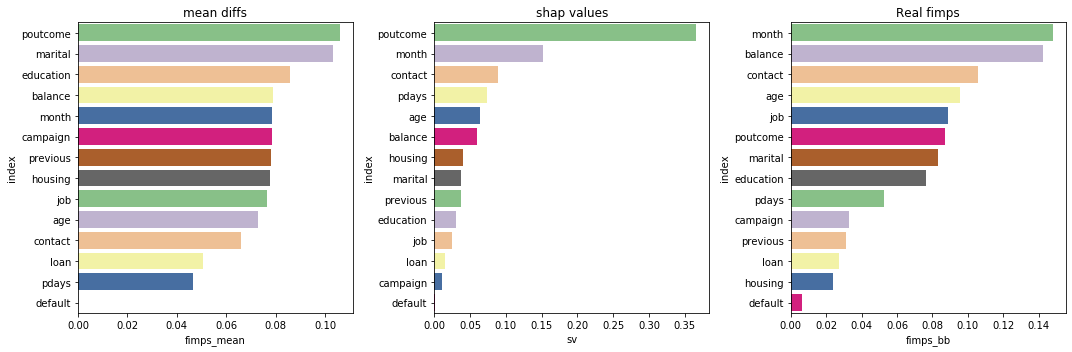

In [651]:
plt.figure(figsize=(15,5))
plt.subplot(131)
#sns.barplot(y='index', x='fimps_mean', data=cds.sort_values('fimps_mean', ascending=False), order='fimps_mean', palette='Accent')
sns.barplot(y='index', x='fimps_mean', data=cds, order=cds.sort_values('fimps_mean', ascending=False)['index'], palette='Accent')
plt.title('mean diffs')

plt.subplot(132)
sns.barplot(y='index', x='sv', data=cds, order=cds.sort_values('sv', ascending=False)['index'], palette='Accent')
plt.title('shap values')

plt.subplot(133)
sns.barplot(y='index', x='fimps_bb', data=cds, order=cds.sort_values('fimps_bb', ascending=False)['index'], palette='Accent')
plt.title('Real fimps')

plt.tight_layout()
plt.show()

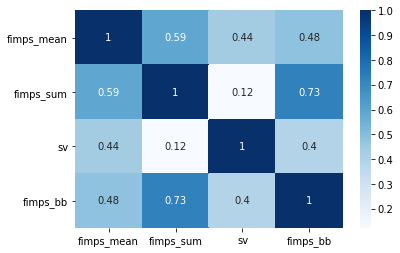

In [652]:
cds_ = cds[['fimps_mean','fimps_sum','sv','fimps_bb']].corr()
sns.heatmap(cds_, cmap='Blues', annot=True)

In [653]:
for f in ['fimps_mean','fimps_sum','sv','fimps_bb']:
    cds[f+'_rank'] = len(cds)-cds[f].rank()

In [654]:
from scipy.stats import mannwhitneyu

In [655]:
mannwhitneyu(cds['fimps_mean'], cds['fimps_bb'])

MannwhitneyuResult(statistic=95.0, pvalue=0.45427439908546097)

In [656]:
mannwhitneyu(cds['fimps_mean'], cds['sv'])

MannwhitneyuResult(statistic=59.0, pvalue=0.03844813197188486)

# Интерпретируем минимальные понятия

In [659]:
sc = select_smallest_covering_hyps([c for c in fm_stab.get_concepts() if c._metrics['strongness']>=0.75], use_pruning=True)
len(sc), len(calc_cover_of_concepts(sc)), len(calc_cover_of_concepts(sc))/flg.sum()

(8, 124, 0.8322147651006712)

In [660]:
[len(c.get_extent()) for c in sc]

[94, 12, 5, 27, 16, 11, 5, 9]

In [661]:
len(calc_cover_of_concepts(sc[:7]))/flg.sum()

0.8187919463087249

In [662]:
def get_short_intent(int_, cntx_full, use_tqdm=True):
    keys = list(int_.keys())
    for i in tqdm(range(len(keys)), disable=not use_tqdm):
        for m in keys:
            if len(cntx_full.get_extent({m_:int_[m_] for m_ in keys if m_!=m}))==len(cntx_full.get_extent(int_)):
                #print(m)
                keys = [m_ for m_ in keys if m_!=m]
                break
        else:
            break
    int_short = {m:int_[m] for m in keys}
    return int_short

In [663]:
from scipy.stats import entropy

In [664]:
def calc_feature_entropy(objs, f, ds):
    ps = ds[f].value_counts()
    qs = ds.loc[ext_, f].value_counts()
    for p in ps.index:
        if p not in qs.index:
            qs[p] = 0
    ps = ps.sort_index()
    qs = qs.sort_index()
    ent = entropy(qs, ps)
    return ent

## Понятие 1

In [665]:
c = sc[0]

In [666]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [667]:
len(int_), len(int_short)

(14, 4)

In [668]:
keys = list(int_short.keys())

In [669]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [670]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(94,
 0.6308724832214765,
 {'strongness': 0.7833333333333333,
  'stab_min_bound': 0.9990234375,
  'stab_max_bound': 0.9990234375,
  'log_stab_min_bound': 10.0,
  'log_stab_max_bound': 10.0,
  'lstab_min_bound': -4.0,
  'n_uncovered': 94})

In [671]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

contact ('cellular', 'telephone')
age (26, 79)
poutcome success
balance (-242, 8556)


## Понятие 2

In [672]:
c = sc[1]

In [673]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [674]:
len(int_), len(int_short)

(14, 7)

In [675]:
keys = list(int_short.keys())

In [676]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [677]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(12,
 0.08053691275167785,
 {'strongness': 0.8571428571428571,
  'stab_min_bound': 0.96875,
  'stab_max_bound': 0.96875,
  'log_stab_min_bound': 5.0,
  'log_stab_max_bound': 5.0,
  'lstab_min_bound': -9.0,
  'n_uncovered': 8})

In [678]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

education ('primary', 'secondary', 'tertiary')
job ('blue-collar', 'entrepreneur', 'management', 'services', 'student')
month ('aug', 'jul', 'oct', 'sep')
previous (1, 4)
pdays (105.0, 474.0)
poutcome ('failure', 'success')
balance (64, 2543)


## Понятие 3

In [679]:
c = sc[2]

In [680]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [681]:
len(int_), len(int_short)

(13, 7)

In [682]:
keys = list(int_short.keys())

In [683]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [684]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(5,
 0.03355704697986577,
 {'strongness': 1.0,
  'stab_min_bound': None,
  'stab_max_bound': None,
  'log_stab_min_bound': None,
  'log_stab_max_bound': None,
  'lstab_min_bound': None,
  'n_uncovered': 5})

In [685]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

education secondary
contact ('cellular', 'telephone')
marital ('divorced', 'single')
job ('admin.', 'retired', 'services')
month ('jun', 'mar', 'oct')
age (42, 74)
balance (-247, 4079)


## Понятие 4

In [686]:
c = sc[3]

In [687]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [688]:
len(int_), len(int_short)

(14, 9)

In [689]:
keys = list(int_short.keys())

In [690]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [691]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(27,
 0.18120805369127516,
 {'strongness': 0.7941176470588235,
  'stab_min_bound': 0.984375,
  'stab_max_bound': 0.984375,
  'log_stab_min_bound': 6.0,
  'log_stab_max_bound': 6.0,
  'lstab_min_bound': -8.0,
  'n_uncovered': 5})

In [693]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

loan 0
education ('primary', 'secondary', 'tertiary')
job ('admin.', 'housemaid', 'management', 'self-employed', 'services', 'technician')
month ('apr', 'feb', 'jul', 'jun', 'mar', 'oct')
previous (1, 5)
pdays (64.0, 192.0)
age (26, 64)
poutcome ('other', 'success')
balance (19, 9756)


## Понятие 5

In [694]:
c = sc[4]

In [695]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [696]:
len(int_), len(int_short)

(14, 11)

In [697]:
keys = list(int_short.keys())

In [698]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [699]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(16,
 0.10738255033557047,
 {'strongness': 0.8,
  'stab_min_bound': 0.998046875,
  'stab_max_bound': 0.9990234375,
  'log_stab_min_bound': 9.0,
  'log_stab_max_bound': 10.0,
  'lstab_min_bound': -4.0,
  'n_uncovered': 4})

In [700]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

loan 0
housing 0
education ('secondary', 'tertiary', 'unknown')
marital ('married', 'single')
job ('admin.', 'retired', 'student', 'technician', 'unemployed', 'unknown')
month ('feb', 'jan', 'jul', 'jun', 'mar', 'oct')
previous (1, 6)
pdays (91.0, 683.0)
age (21, 66)
poutcome ('failure', 'success')
balance (113, 3676)


## Понятие 6

In [701]:
c = sc[5]

In [702]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [703]:
len(int_), len(int_short)

(13, 7)

In [704]:
keys = list(int_short.keys())

In [705]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [706]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(11,
 0.0738255033557047,
 {'strongness': 0.7857142857142857,
  'stab_min_bound': 0.984375,
  'stab_max_bound': 0.984375,
  'log_stab_min_bound': 6.0,
  'log_stab_max_bound': 6.0,
  'lstab_min_bound': -8.0,
  'n_uncovered': 4})

In [707]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

education ('primary', 'secondary', 'unknown')
contact ('cellular', 'telephone')
marital ('divorced', 'married')
job ('admin.', 'management', 'retired', 'technician')
month ('dec', 'jun', 'mar')
age (53, 83)
balance (259, 3735)


## Понятие 7

In [708]:
c = sc[6]

In [709]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [710]:
len(int_), len(int_short)

(14, 6)

In [711]:
keys = list(int_short.keys())

In [712]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [713]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(5,
 0.03355704697986577,
 {'strongness': 1.0,
  'stab_min_bound': None,
  'stab_max_bound': None,
  'log_stab_min_bound': None,
  'log_stab_max_bound': None,
  'lstab_min_bound': None,
  'n_uncovered': 2})

In [714]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

campaign (1, 3)
job ('admin.', 'retired', 'services', 'unemployed')
month ('aug', 'dec', 'jul')
pdays (181.0, 761.0)
age (35, 60)
balance (978, 4256)


## Понятие 8

In [715]:
c = sc[7]

In [719]:
int_ = c.get_intent()
int_short = get_short_intent(int_, mvcntx_full, use_tqdm=False)

#int_ = sorted(int_, key=lambda x: x.split('__')[0])
#int_short = sorted(int_short, key=lambda x: x.split('__')[0])

In [720]:
len(int_), len(int_short)

(14, 8)

In [721]:
keys = list(int_short.keys())

In [722]:
entrs = []
for f in keys:
    entrs.append( calc_feature_entropy(c.get_extent(), f, bank_ds.loc[flg] ) )
entrs = pd.Series(entrs, index=keys).sort_values()

In [723]:
len(c.get_extent()), len(c.get_extent())/flg.sum(), c._metrics

(9,
 0.06040268456375839,
 {'strongness': 1.0,
  'stab_min_bound': None,
  'stab_max_bound': None,
  'log_stab_min_bound': None,
  'log_stab_max_bound': None,
  'lstab_min_bound': None,
  'n_uncovered': 2})

In [724]:
for k in entrs.index:
    if k in int_short:
        print(k, int_short[k])

loan 0
campaign (1, 2)
job ('housemaid', 'management', 'retired', 'services', 'student')
month ('dec', 'jun', 'may', 'nov')
previous (2, 10)
pdays (38.0, 185.0)
poutcome ('other', 'success')
balance (883, 7802)


# Attribute Information:

Input variables:

__bank client data:__
1. - age (numeric)
2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services") 
3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
4. - education (categorical: "unknown","secondary","primary","tertiary")
5. - default: has credit in default? (binary: "yes","no")
6. - balance: average yearly balance, in euros (numeric) 
7. - housing: has housing loan? (binary: "yes","no")
8. - loan: has personal loan? (binary: "yes","no")

__related with the last contact of the current campaign:__
9. - contact: contact communication type (categorical: "unknown","telephone","cellular") 
10. - day: last contact day of the month (numeric)
11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
12. - duration: last contact duration, in seconds (numeric)

__other attributes:__
13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
15. - previous: number of contacts performed before this campaign and for this client (numeric)
16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target):
17. - y - has the client subscribed a term deposit? (binary: "yes","no")